# Dual-branched DNN with Multi-Output and Multi-Loss - Car Reservation Prediction 

# Overview
Our goal is to predict the number of reservations of vehicles (number of unique reservations per vehicle (non-negative numeric) and reservation type (categorical)) using six input features. The two output variables makes this a multi-output problem. We have several options to build a multi-output deep neural network: (1) Create an output layer using sigmoid with a single loss "MSE" for the categorical and the scaled numeric variable (between -1 and 1), or even better (2) create a dual-branched DNN with an independent sigmoid output layer for the categorical output with categorical cross-entropy loss, and a ReLU linear regression output layer for the non-negative numeric variable with MSE loss.

Benchmark ML approaches using a multi-feature linear regression model and SVM (for numeric output), and a logistic regression (for categorical output) will be developed to compare with the dual-branched DNN.

What's learned?
* Building dual-branched DNN by utilizing both categorical loss and numerical loss
* Exploring the feature space by PCA and cosine similarity function
* Comparing benchmark models: SVM with RBF kernel, softmax regression, multilinear regression
* Using `argparse` to perform production ready API

# Background

My math notebooks ([support vector machine](https://github.com/ginochen/ML_notes/blob/master/support_vector_machine.ipynb), [logistic regression](https://github.com/ginochen/ML_notes/blob/master/logistic_regression_cross_entropy.ipynb), [stochastic gradient descent](https://github.com/ginochen/ML_notes/blob/master/stochastic_gradient_descent.ipynb)) for the ML tools used in this project serve as reminders of what's really happening algorithmically in the python packages.



# Data 
Due to confidentiality issues of the data, let's import, clean and PCA transform the feature space. The PCA also serve as a normalizer which makes training converge faster for SVM.

In [1]:
# as before load all lib here
import pandas as pd
import numpy as np
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression # logistic regression function p(x) = 1/(1+e^{b^T*x}), logit(p) = b^T*x
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.utils import shuffle

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed, Activation, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
import numpy as np
class measures():
    def __init__(self,y):
        self.y = y
    def mad(self): # median_absolute_deviation, measures the variability of a 1-D data
        return np.median(np.absolute(self.y - np.median(self.y))) # MAD
    @staticmethod
    def mse(y,z): # no need to load sklearn, just use this like a regular function, data_measures.mean_squared_error(np.array([3,5,7]),np.array([1,3,4]))
        return np.mean((y - z)**2) # mean_squared_error
        

In [3]:
prediction_samp=10000

In [4]:
df_vehicles = pd.read_csv('./vehicles.csv')
df_reservations = pd.read_csv('./reservations.csv')

In [5]:
#print('VEHICLES\n =============================================== \n',df_vehicles.head(4))
#print('\nRESERVATIONS\n ========================================== \n',df_reservations.head(4))

In [6]:
df = pd.merge(df_reservations,df_vehicles, how='inner', on='vehicle_id') # join on intersection on vehicle_id
tmp = df.groupby('vehicle_id').reservation_id.nunique().to_frame()
tmp.columns = ["n_reserve"] # rename the column to number of reservations for each unique vehicle ID
df = pd.merge(df,tmp,how='inner',on='vehicle_id')
#drop_duplicates() 
#print(df.iloc[:5,:])

In [7]:
print('(samples, features) = %s'%str(df.shape))
print('max description length = %s'%str(df.description_length.max()))

(samples, features) = (195243, 10)
max description length = 7780


Let's checkout the feature space characteristics! Instead of using all 6 dim, which is hard to visualize, let's just look at the top 3 principle axes feature space:

In [8]:
nrows = df.shape[0]
#df = df.dropna(axis=0) # drop NaNs
#x = df.iloc[:, [2,4,5,8]].values
x = df.iloc[:, range(3,9)].values # skip is_delivery since it's the tag
print('x = \n%s'%str(df.iloc[0,range(3,9)]))
y_num = df['n_reserve'].values # the tag to color mark on projected features
y_cat = df['reservation_type'].values
y_cat[np.isnan(y_cat)]=0
lb = preprocessing.LabelBinarizer()
y_catx = lb.fit_transform(y_cat) # binarizer transformed y_cat into [nsamples,n_cats] matrix
print('\ny_num: \nnumber of reservation = %s \n\ny_cat: \nreservation_type = %s'%(str(y_num),str(set(y_cat))))
print('\ny_catx: reservation_type binarized = %s'%str(y_catx[:2,:]))

x = 
is_delivery             0.0
actual_price          121.0
recommended_price      48.0
num_images              9.0
description_length      0.0
is_recent_model         0.0
Name: 0, dtype: float64

y_num: 
number of reservation = [ 2  2 11 ...  0  0  0] 

y_cat: 
reservation_type = {0.0, 1.0, 2.0}

y_catx: reservation_type binarized = [[0 0 1]
 [0 0 1]]


Let's split the reservation number into two classes (reservation_type= {0,1}, {2}), and get a first look at how similar the classes are using cosine similarity function. Note that cosine similarity results are similar if we changed the class to using n_reservation with any threshold (e.g., threhold=15):

In [9]:
def average_cosine_similarity(x,y,nsamp):
    '''
    x:  feature matrix [n_samples, n_features]
    y:  class vector   [n_samples]
    nsamp: number of samples to compute cosine similarity
    '''
    x1 = x[y==1,:] # class 1 feature data
    x0 = x[y==0,:] # class 0 feature data
    if nsamp>x1.shape[0] | nsamp>x0.shape[0]:
        nsamp = min(x1.shape[0],x0.shape[0])
        print('Use the lesser samples  = %s'%str(nsamp))
    cs01 = cosine_similarity(x1[:nsamp,:],x0[:nsamp,:]) # computes cosine simlilarity between all pairwise samples in x1 and x0
    #ed01 = np.linalg.norm(x1[:nsamp,:]-x0[:nsamp,:])
    plt.hist(cs01.reshape(-1,1),100); plt.show()
    
    print('The average cosine similarity = %s'%str(np.mean(cs01.reshape(-1,1))))
    print('The median cosine similarity = %s'%str(np.median(cs01.reshape(-1,1))))

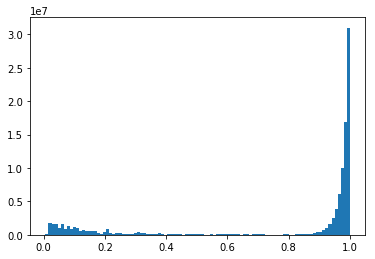

The average cosine similarity = 0.7817874561749854
The median cosine similarity = 0.9784254425331133


In [10]:
thres = 1
average_cosine_similarity(x,y_cat>thres,10000)
#np.linalg.norm(a-b) maybe do pairwise distance?

The cosine similarity distribution is extremely skewed with very high median near 1, i.e., very similar sample features. And the average cosine similarity between the two classes are very high, meaning they are hard to separate in feature space.

Let's see if doing PCA transform can help separate the two sample classes:

In [11]:
pca = PCA(n_components=x.shape[1]) # use all 
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:
s = pca.singular_values_
print(s)  # just the eigenvalues of the PC direction vectors, also the stdev of the PCs

[2.36941876e+05 3.17776567e+04 8.00781480e+03 2.23030351e+03
 2.05296110e+02 1.88772658e+02]


In [13]:
print(pca.explained_variance_ratio_) # ([i/sum(pca.singular_values_**2) for i in pca.singular_values_**2])

[9.81143164e-01 1.76478773e-02 1.12066750e-03 8.69313996e-05
 7.36563472e-07 6.22768905e-07]


The sigular values are just the PC stdev of the PC axes, and the explained variance are just the component variances (i.e., squared stdev) divide by the total variance. The top two axes captures >98% of the variance.

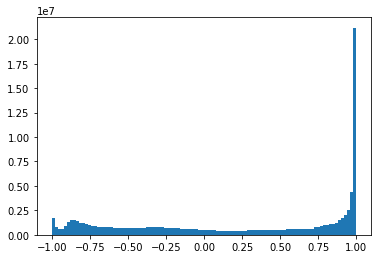

The average cosine similarity = 0.2257814859155804
The median cosine similarity = 0.4077201168991951


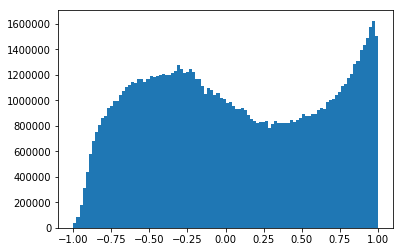

The average cosine similarity = 0.05707507955914302
The median cosine similarity = 0.00484748659307534


In [14]:
P = pca.transform(x) # the projection of all samples on all PC axes, 
PC_normal = np.asarray([P[:,i]/s[i] for i in range(len(s))]).T # normalized PC: PC divided by sigular values
# we can use P = PCA(n_components=2).transform(x)  if we just want the projections on the first 2 components, 
# this gives the same values as the full transformation, but just trancated 
average_cosine_similarity(PC_normal[:,:2],y_cat>1,10000) # computes cosine simlilarity between all pairwise samples in x1 and x0
average_cosine_similarity(PC_normal[:,:4],y_cat>1,10000) # computes cosine simlilarity between all pairwise samples in x1 and x0


Despite top 2 PC axes capturing most of the variance, the cosine similarity distribution is much more spreaded over -1 to 1 by using top 4 PC axes, without high similarity samples. The mean and median consine similarity are very low, which shows that the two classes in PCA feature space are probably more separated.

Let's see how the projection behaves on the 2 and 3 leading PC axes in a plot:

Samples: Class 0 (red) = 1355, Class 1 (blue) = 112740, Class 2 (green) = 81148


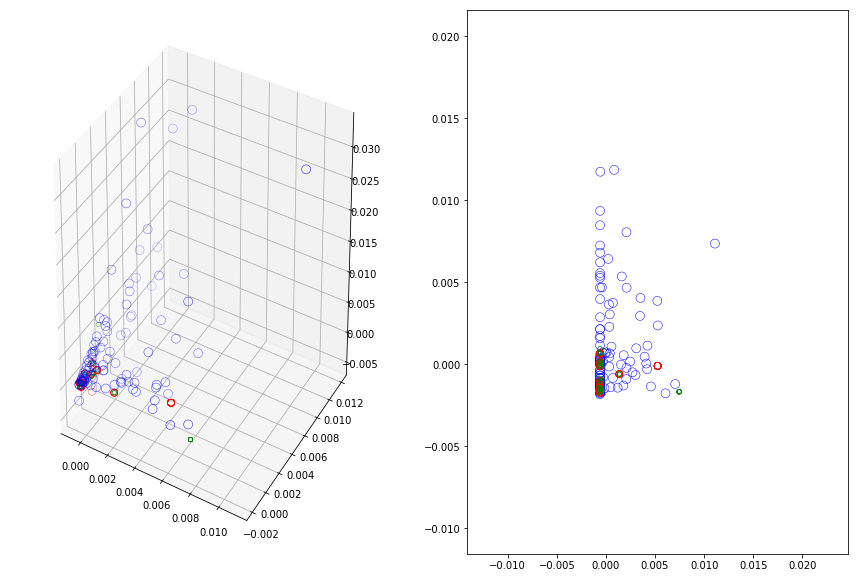

In [15]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121, projection='3d')
print("Samples: Class 0 (red) = %s, Class 1 (blue) = %s, Class 2 (green) = %s"%(sum(y_cat==0),sum(y_cat==1),sum(y_cat==2)))
ax.scatter(PC_normal[y_cat==0,0][:100], PC_normal[y_cat==0,1][:100], PC_normal[y_cat==0,2][:100], edgecolors='b', s=80, facecolors='none', linewidths=0.5, label='Class 0')
ax.scatter(PC_normal[y_cat==1,0][:100], PC_normal[y_cat==1,1][:100], PC_normal[y_cat==1,2][:100], edgecolors='r', s=50, facecolors='none', linewidths=0.5, label='Class 1')
ax.scatter(PC_normal[y_cat==2,0][:100], PC_normal[y_cat==2,1][:100], PC_normal[y_cat==2,2][:100], edgecolors='g', s=20, facecolors='none', linewidths=0.5, label='Class 2')

ax2 = fig.add_subplot(122)
ax2.scatter(PC_normal[y_cat==0,0][:100], PC_normal[y_cat==0,1][:100], edgecolors='b', s=80, facecolors='none', linewidths=0.5, label='Class 0')
ax2.scatter(PC_normal[y_cat==1,0][:100], PC_normal[y_cat==1,1][:100], edgecolors='r', s=50, facecolors='none', linewidths=0.5, label='Class 1')
ax2.scatter(PC_normal[y_cat==2,0][:100], PC_normal[y_cat==2,1][:100], edgecolors='g', s=20, facecolors='none', linewidths=0.5, label='Class 2')
plt.show()

Seems like the three classes are better separated (except some outliers) in the PCA feature space. We want to see if the highly nonlinear DNN with multi-output architecture captures this nonlinear decision boundary!

Since rescaling is recommended for reasons such as making feature space more "spherical" instead of "elliptical" to speed up the stochastic gradient descent. Therefore we will just work on the normalized PC to avoid using `sklearn.preprocessing` to rescale the data.

We are going to look at multi-linear regression (for n_reservation label), softmax regression (for reservation_type label), SVM (for reservation_type label) and finally DNN (for both reservation_type and n_reservation labels).

Let's split the data into 80% training, 10% validation and 10% testing:

In [16]:
PC_normal,x,y_num,y_catx = shuffle(PC_normal,x,y_num,y_catx,random_state=0) # shuffle along the first axis to de-order the samples
#scaler = preprocessing.StandardScaler().fit(x) # standard normal z-scaling
#xz = scaler.transform(x) # z-scaling
#x_train,x_valid,x_test = x[:ntrain,:], x[ntrain:nvalid,:], x[nvalid:,:] # no scaling
#x_train,x_valid,x_test = xz[:ntrain,:], xz[ntrain:nvalid,:], xz[nvalid:,:] # z scaling
nPC = [5] # used number of PCA features for prediction
def split_train_valid_test(x,proportion=[0.8,0.9]):
    ntrain = round(proportion[0]*x.shape[0])
    nvalid = round(proportion[1]*x.shape[0])
    return x[:ntrain], x[ntrain:nvalid], x[nvalid:] 
# use only the highest variance PC axes, which is the top 2
x_train,x_valid,x_test             = split_train_valid_test(PC_normal[:,nPC])
y_num_train,y_num_valid,y_num_test = split_train_valid_test(y_num)
y_cat_train,y_cat_valid,y_cat_test = split_train_valid_test(y_catx)
print(x_train.shape, x_valid.shape, x_test.shape, y_num_train.shape, y_cat_train.shape)

(156194, 1) (19525, 1) (19524, 1) (156194,) (156194, 3)


# Train Models

### Multi-linear Regression

In [17]:
reg = LinearRegression().fit(x_train,y_num_train)
reg.score(x_train,y_num_train)
y_pred_linreg = reg.predict(x_test[:prediction_samp])
print('Mean squared error = %s'%str(mean_squared_error(y_num_test[:prediction_samp],y_pred_linreg)))

Mean squared error = 111.7700847405627


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### Logistict Regression
Let's start with logistic regression:

In [18]:
logreg = LogisticRegression(C=1e5, solver='lbfgs',multi_class='multinomial').fit(x_train,lb.inverse_transform(y_cat_train)) # multinomial uses cross entropy 
y_pred_lr = logreg.predict(x_test)
y_predp_lr = logreg.predict_proba(x_test)
print(classification_report(lb.inverse_transform(y_cat_test),y_pred_lr,target_names=['class 0','class 1','class 2'])) # support is just the # of samples detected or used
# X = [n_samples, n_features], y = [n_samples]
# C = Inverse of regularization strength; must be a positive float. 
#     Like in support vector machines, smaller values specify stronger regularization.
# solver = 'sag': stochastic average gradient descent
#        = 'lbfgs': some Newton method
print('first two actual classes = %s'%str(y_cat_test[:2]))
print('first two predicted classes = %s'%str(logreg.predict(x_test[:2,:]))) # predict class vs real class
print('first two predicted probalities [0 vs 1] = %s'%str(logreg.predict_proba(x_test[:2,:]))) # predict
# print('score = %s'%str(logreg.score(x_test,y_test))) # Score is the ratio of correctly predicted (TP+TN) samples.

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       118
     class 1       0.58      1.00      0.73     11246
     class 2       0.00      0.00      0.00      8160

   micro avg       0.58      0.58      0.58     19524
   macro avg       0.19      0.33      0.24     19524
weighted avg       0.33      0.58      0.42     19524

first two actual classes = [[0 1 0]
 [0 0 1]]
first two predicted classes = [1. 1.]
first two predicted probalities [0 vs 1] = [[0.00699195 0.61242852 0.38057954]
 [0.00717669 0.55104557 0.44177773]]


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score is pretty bad...

### SVM
SVM with kernel computes the distance between every training points which is super expensive O($n_\text{features} \times n_\text{observations}^2$), so reduce the training samples to <100000, and don't do parameter grid search:

In [19]:
clf = SVC(gamma='auto') # For non-linear classification use 
                        # gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. 
                        # Default is set to 'rbf' which is Radial Basis Function kernel
                        # multiclass uses one-vs-one, very slow...
clf.fit(x_train[:50000,:], lb.inverse_transform(y_cat_train[:50000,:]))
y_pred_svc = clf.predict(x_test)
print(x_test.shape,y_pred_svc.shape,sum(y_pred_svc))
print(classification_report(lb.inverse_transform(y_cat_test),y_pred_svc,target_names=['class 0','class 1','class 2']))
# let's do a grid search over the C and Gamma parameter space, 
# C (=1/\lambda) is a regularization scale , larger (smaller) C gives lower (higher) bias and higher (lower) variance
# Gamma (=1/\sigma) is a scale on kernel "width/variance", larger (smaller) Gamma gives lower (higher) bias and higher (lower) variance
# go to https://github.com/ginochen/ML_notes to learn more about these two parameters   
# The kernel trick is super expensive since it computes distance between each point!!
# see solution https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution
#C_range = np.logspace(-2, 10, 3) # linear spaced between log10scale -2 to 10, and returns 10 based exponents of 10^-2, ...1
#gamma_range = np.logspace(-9, 3, 3) 
#param_grid = dict(gamma=gamma_range, C=C_range) 
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
#grid.fit(x_train, y_train)

#print("The best parameters are %s with a score of %0.2f"
#      % (grid.best_params_, grid.best_score_))

(19524, 1) (19524,) 19524.0
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       118
     class 1       0.58      1.00      0.73     11246
     class 2       0.00      0.00      0.00      8160

   micro avg       0.58      0.58      0.58     19524
   macro avg       0.19      0.33      0.24     19524
weighted avg       0.33      0.58      0.42     19524



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVM is even worse at f1-score...

### Branched DNN - Multi-Output and Multi-Loss

dict_keys(['val_loss', 'val_cat_output_acc', 'val_num_output_loss', 'cat_output_loss', 'val_cat_output_loss', 'val_num_output_acc', 'cat_output_acc', 'num_output_acc', 'num_output_loss', 'loss'])


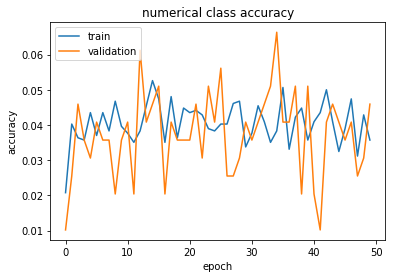

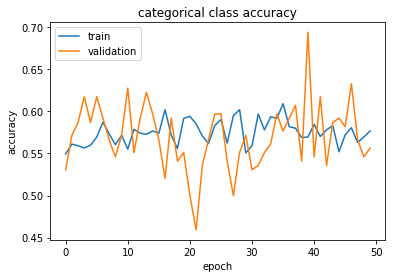

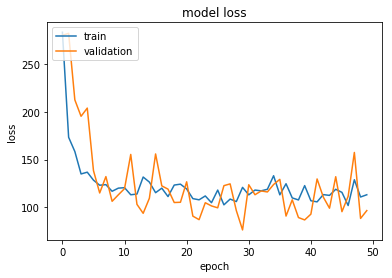

In [20]:
import argparse
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Activation, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer

#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#    help="path to input dataset (i.e., directory of images)")
#ap.add_argument("-m", "--model", required=True,
#    help="path to output model")
#ap.add_argument("-l", "--categorybin", required=True,
#    help="path to output category label binarizer")
#ap.add_argument("-c", "--colorbin", required=True,
#    help="path to output color label binarizer")
#ap.add_argument("-p", "--plot", type=str, default="output",
#    help="base filename for generated plots")
#args = vars(ap.parse_args())

class KerasBatchGenerator(object):
    def __init__(self,x,y_num,y_cat,batchsize,ndim,nsteps,skip_steps):
        self.x=x
        self.y_num=y_num
        self.y_cat=y_cat
        self.batchsize=batchsize
        self.istart=0
        self.nsteps=nsteps
        self.skip_steps = skip_steps
        self.ndim = ndim
    def generate(self):
        x = np.zeros((self.nsteps, self.ndim))            
        y_num = np.zeros((self.nsteps, 1))
        y_cat = np.zeros((self.nsteps, 3))
        while True:
            for i in range(self.batchsize):
                x, y_num, y_cat = self.x[self.istart:self.istart+self.nsteps,:], \
                    self.y_num[self.istart:self.istart+self.nsteps], \
                    self.y_cat[self.istart:self.istart+self.nsteps,:]
                self.istart += self.skip_steps             
                yield x, {'num_output': y_num, 'cat_output': y_cat} # yield returns a set of x,y values for model.fit_generator to perform batch training
        

class branched_dnn(object):
    def __init__(self,fpath):                      
        self.file = fpath+'/best_model.h5'                          
    @staticmethod
    def build_model(fpath,ndim,nepochs=50,hdim=100,hlayers=20,dropoutrate=0.2,learning_rate=0.001):
        inputShape = (ndim,) # does not include the mini-batch/batchsize samples axis
        inputs = Input(shape=inputShape)
        numericBranch  = branched_dnn(fpath).build_branch_model(inputs, \
                         finalAct='relu',name='num_output',nout=1,nin=ndim,hdim=hdim, \
                         hlayers=hlayers,dropoutRate=dropoutRate)
        categoryBranch = branched_dnn(fpath).build_branch_model(inputs, \
                         finalAct='softmax',name='cat_output',nout=3,nin=ndim,hdim=hdim, \
                         hlayers=hlayers,dropoutRate=dropoutRate)
        model = Model(inputs=inputs, outputs=[numericBranch, categoryBranch],name="branchednet")
        losses = {"num_output": "mean_squared_error", "cat_output": "categorical_crossentropy"}
        lossWeights = {"num_output": 1.0, "cat_output": 1.0}
        opt = Adam(lr=learning_rate, decay=learning_rate/nepochs) # with learning rate decay
        model.compile(optimizer=opt, loss=losses, loss_weights = lossWeights, metrics=["accuracy"])
        # checkpointer = keras.callbacks.ModelCheckpoint(filepath=datapath + '/model-{epoch:02d}.hdf5', verbose=1)
        checkpointer = [EarlyStopping(monitor='val_loss', patience=20), # patience: wait for at least 5 epochs before early stopping
        ModelCheckpoint(filepath=branched_dnn(fpath).file, monitor='val_loss', save_best_only=True, verbose=0)]
        # model.summary()
        return model, checkpointer
    def build_branch_model(self,x,finalAct=None,name=None,nout=None,nin=None,hdim=100,hlayers=20,dropoutRate=20):
        '''
        finalAct: 'softmax','sigmoid' for categorical, 'linear' or 'relu' for numerical
        name: just name the branches as you wish, e.g., 'category_output', 'numeric_output'
        '''
        #model = Sequential()
        x = Dense(hdim, input_dim=nin, kernel_initializer='glorot_normal')(x)
        BatchNormalization()
        x = Activation('relu')(x)
        for _ in range(hlayers-1):
            x = Dropout(dropoutRate)(x)
            #model.add(Dense(hdim, kernel_initializer='glorot_normal', activation='relu')) 
            x = Dense(hdim, kernel_initializer='glorot_normal')(x) 
            BatchNormalization()
            x = Activation('relu')(x)
            #model.add(Dense(1,kernel_initializer='glorot_normal', activation='sigmoid')) # determine the probability of anomaly 
            #model.add(LeakyReLU(alpha=0.3)) # f(x) = 0.3*x, 0.3 is a small gradient
        x = Dense(nout,kernel_initializer='glorot_normal')(x) # determine the number
        BatchNormalization()
        x = Activation(finalAct,name=name)(x)
        return x
    @staticmethod
    def plot_hist(hist):
        # list all data in history
        print(history.history.keys())
        # summarize history for numerical value accuracy
        plt.plot(history.history['num_output_acc'])
        plt.plot(history.history['val_num_output_acc'])
        plt.title('numerical class accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        # summarize history for categorical value accuracy
        plt.plot(history.history['cat_output_acc'])
        plt.plot(history.history['val_cat_output_acc'])
        plt.title('categorical class accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

# Define model parameters
fpath = './'
batchsize = 100 # number of mini-batches per epoch
nsteps = 28 # number of samples in each mini-batch
ndim = x_train.shape[1]  # feature dimensions
hdim = 100 # hidden layer dimensions
hlayers= 20 # hidden layers
last_epoch = 0 # set to 0 for new model training
nepochs=50
dropoutRate = 0.5
learningRate=0.001
prediction_samp = 10000
ntrain = x_train.shape[0]
nvalid = x_valid.shape[0]

# initialize training and validation mini-batch data generator
train_gen = KerasBatchGenerator(x_train,y_num_train,y_cat_train, 
                          batchsize, ndim, nsteps, skip_steps=nsteps)
valid_gen = KerasBatchGenerator(x_valid,y_num_valid,y_cat_valid, 
                          batchsize, ndim, nsteps, skip_steps=nsteps)
#test_gen  = KerasBatchGenerator(np.concatenate((x_test,y_test.reshape(-1,1)),axis=1), 
#                          10, ndim, 1000, skip_steps=nsteps)
model, checkpointer  = branched_dnn(fpath).build_model(fpath,ndim,nepochs=nepochs,hdim=hdim,hlayers=hlayers,
                                   dropoutrate=dropoutRate,learning_rate=learningRate)
history = model.fit_generator(train_gen.generate(), ntrain//(batchsize*nsteps), epochs=last_epoch+nepochs,
                validation_data = valid_gen.generate(), validation_steps=math.ceil(nvalid/(batchsize*nsteps)),
                callbacks=checkpointer,shuffle=True,initial_epoch=last_epoch,verbose=0)
branched_dnn.plot_hist(history)
#dict_keys(['num_output_acc', 'val_num_output_acc', 'loss', 'val_num_output_loss', 
#           'val_cat_output_loss', 'cat_output_loss', 'cat_output_acc', 'val_loss', 
#           'num_output_loss', 'val_cat_output_acc'])
#model = keras.models.load_model('./best_model.h5')
y_pred_dnn = model.predict_on_batch(x_test[:prediction_samp,:]) # predict on a single batch
y_cat_true_dnn = y_cat_test[:prediction_samp,:]
y_num_true_dnn = y_num_test[:prediction_samp]

The accuracy of the two outputs saturated early at very low values!

In [21]:
def cat_crossentropy(y_true,y_pred):
    entropy=0
    for i in range(y_true.shape[0]):
        entropy -= math.log(y_pred[i,y_true[i]==1]) # y_true: 0,1,2 are also the column index of y_pred
    return entropy/y_true.shape[0]
print('MSE = %s'%str(mean_squared_error(y_pred_dnn[0],y_num_true_dnn)))
cce = cat_crossentropy(y_cat_true_dnn,y_pred_dnn[1])
print('Categorical cross entropy = %s = average targeted probability of %s%%!'%(str(cce),str(round(math.exp(-cce)*100))))
print(classification_report(lb.inverse_transform(y_cat_true_dnn),lb.inverse_transform(y_pred_dnn[1]),target_names=['class 0','class 1','class 2']))


MSE = 111.95302345298997
Categorical cross entropy = 0.7119541988522946 = average targeted probability of 49%!
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00        57
     class 1       0.58      1.00      0.73      5770
     class 2       0.00      0.00      0.00      4173

   micro avg       0.58      0.58      0.58     10000
   macro avg       0.19      0.33      0.24     10000
weighted avg       0.33      0.58      0.42     10000



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Notice the MSE for n_reservation prediction is not lower than any other models. The multi-output training did not result in anything better. In fact the MSE is close to multilinear regression and f1-score is close to SVM and lower than softmax regression. 

# Discussion 
I should probably tryp dropping the reservation_type that are nan, instead of defining them as 0 since not yet reserved cars doesn't mean anything.

# Reference
* [Endless run of kernel SVM](https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution)
* [mathematical formulation of SVC](https://scikit-learn.org/stable/modules/svm.html)
* [argparse](https://www.pyimagesearch.com/2018/03/12/python-argparse-command-line-arguments/)
* [multi-output DNN](https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/)